# Environment setup

In [37]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error,make_scorer, accuracy_score, classification_report, confusion_matrix,roc_curve
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import plot_roc_curve
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from xgboost import plot_importance



# Section 1. Business Understanding

This project is a requirement of the Udacity Data Science Nanodegree. The project consists of answering three business questions from a public data set. Throughout this project we are going to answer three business questions about assesing credit risk:

- Is there any valuable information in the sociodemographic data?
- Is there any valuable information in the credit behaviour data?
- how to make an accurate credit score?

# Section 2. Data Understanding

## Gather

You can download the dataset we are going to use through the notebook [here](https://www.kaggle.com/c/GiveMeSomeCredit/data)

In [2]:
#loading the dataset
DATA_PATH='./cs-training.csv'
loans = pd.read_csv(DATA_PATH)
loans.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


The **Give me Some Credit** dataset contains information about credit behaviour, it contains 12 variables:<br>


| **Variable Name** | **Description** | **Type** |
| :- | -: | :-: |
| _<font color=red>SeriousDlqin2yrs</font>_ | <font color=red>Person experienced 90 days past due delinquency or worse</font>  | <font color=red>Y/N</font> |
| _RevolvingUtilizationOfUnsecuredLines_ | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits | percentage |
| _age_ | Age of borrower in years | integer |
| _NumberOfTime30-59DaysPastDueNotWorse_ | Number of times borrower has been 30-59 days past due but no worse in the last 2 years. | integer |
| _DebtRatio_ | Monthly debt payments, alimony,living costs divided by monthy gross income | percentage |
| _MonthlyIncome_ | Monthly income | real |
| _NumberOfOpenCreditLinesAndLoans_ | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) | integer|
| _NumberOfTimes90DaysLate_ | Number of times borrower has been 90 days or more past due. | integer |
| _NumberRealEstateLoansOrLines_ | Number of mortgage and real estate loans including home equity lines of credit | integer |
| _NumberOfTime60-89DaysPastDueNotWorse_ | Number of times borrower has been 60-89 days past due but no worse in the last 2 years. | integer |
| _NumberOfDependents_ | Number of dependents in family excluding themselves (spouse, children etc.) | integer |


The variable highlighted in **<font color=red>red</font>** corresponds to the Target variable, The other 10 features are the ones we are going to use to predict whether a customer present a default in the next two years.

## Exploratory data analysis 

Before Answering the business questions stated we have to perform a thorough data analysis to identify and correct any issues that the dataset can contain.

- **Dataset dimention**

In [3]:
loans.shape

(150000, 12)

The shape shows that we have 150,000 obsevations and 12 features. <br> Since the data dictionary have only 11 features described, we are going to find which column doesn't belong to the dataset

In [4]:
#list the columns
loans.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

From the list of columns we can identify a column that doesn't belong to the dictionary  **<font color=red>'Unnamed: 0'</font>** , has a name that doesn't match the naming convention of the dataset. <br>
To be completely sure that we can ignore that column, we are going to do a descriptive analysis on that column.

In [5]:
loans['Unnamed: 0'].describe()

count    150000.000000
mean      75000.500000
std       43301.414527
min           1.000000
25%       37500.750000
50%       75000.500000
75%      112500.250000
max      150000.000000
Name: Unnamed: 0, dtype: float64

From the analysis we can observe, the minimum is 1, the maximum is equal to the number of observations, and the mean is exactly half between 1 and 150,000. that behavior means that the column is a **unique identifier** starting at one with steps of one. Given that, there is no harm in exercising to remove the spine.

In [6]:
loans= loans.drop('Unnamed: 0', axis=1)

In [7]:
loans.shape

(150000, 11)

We can observe that the shape of the dataset is now consistent with the expected from the dictionary.

- **Descriptive Stats**

In [8]:
loans.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


From the data description we can adress some problems with some of the features in the dataset:<br>
- **<font color=red>SeriousDlqin2yrs :</font>**<br> binary feature wit 6.68% of ones
- **RevolvingUtilizationOfUnsecuredLines :** <br>Since this variable is a percentage that represents the relationship between balance and credit limit, there is no way that any bank allows exceeding the credit limit by a factor of 50,000 or higher as evidenced in the maximum, those values are distorting the mean and standard deviation of the characteristic. we are going to do more analysis to define how to tackle this isue. 
- **age :** <br>Although it is possible for a human being to live 109 years it is highly unlikely, and from a business perspective there is no way for a bank to issue a loan to someone 0 years old. More analysis will be done.
- **NumberOfTime30-59DaysPastDueNotWorse**<br> Two years has 24 months therefore is not posible for the column to present values over 24
- **DebtRatio**<br> It is posible to have values over 1, but 329664 seems a data mistake.}
- **MonthlyIncome**<br> the values of the column seems reasonable there are people that can earn 3 million monthly.
- **NumberOfOpenCreditLinesAndLoans**<br> the values of the column seems reasonable.
- **NumberOfTimes90DaysLate**<br>Two years has 24 months therefore is not posible for the column to present values over 24
- **NumberRealEstateLoansOrLines**<br> the values of the column seems reasonable.
- **NumberOfTime60-89DaysPastDueNotWorse**<br> Two years has 24 months therefore is not posible for the column to present values over 24
- **NumberOfDependents**<br> althoug 20 dependants seems too much is posible.

# Section 3. Data Preparation

First of all we are going to rename a couple of variables because its names could arise problems in the code

In [9]:
loans['NumberOfTime30_59DaysPastDueNotWorse']=loans['NumberOfTime30-59DaysPastDueNotWorse']
loans= loans.drop('NumberOfTime30-59DaysPastDueNotWorse', axis=1)
loans['NumberOfTime60_89DaysPastDueNotWorse']=loans['NumberOfTime60-89DaysPastDueNotWorse']
loans= loans.drop('NumberOfTime60-89DaysPastDueNotWorse', axis=1)


## Data cleaning

all the identified outlier will be removed, as well de missing values in the column monthly income because the form a business perspective it doesn´t make sense

In [10]:

def OutlierSelection(col,data): 
    '''
    Function that detects outliers for the data, this method for outliers detection fits best the data because the std in most 
    of the features is much drater than the 75th percentile.

    Input 
       col  = str with the column name
       data = dataframe with the information
    output 
       df   = dataframe with the bins and the counts
    '''
    
    q_u = data[col].quantile(0.75)  # Upper Quartile
    q_l = data[col].quantile(0.25)  # Lower Quartile
    m   = data[col].quantile(0.50)  # Median
    iqr = q_u - q_l                 # InterQuartile Range
    lb = q_l - 1.5 * iqr           # Anithing under 1,5 interquartile can be considered outlier
    ub = q_u + 1.5 * iqr           # Anithing over 1,5 interquartile can be considered outlier
    bins = [float('-inf'), lb, q_l, m, q_u, ub, float('inf')] 
    data['Col_binned']=pd.cut(x = data[col],bins = bins)
    df = data['Col_binned'].value_counts(sort=False)
    data= data.drop('Col_binned', axis=1)
    return(df);

In [11]:
def TwoBinsWithaCut(col,cut,data): 
    
    '''
    Function that returns two bins given a cut.

    Input 
       col  = str with the column name
       cut  = int with the cut
       data = dataframe with the information
    output 
       df   = dataframe with the bins and the counts

    '''

    bins = [float('-inf'), cut, float('inf')] 
    data['Col_binned']=pd.cut(x = data[col],bins = bins)
    df = data['Col_binned'].value_counts(sort=False)
    data= data.drop('Col_binned', axis=1)
    return(df);

- **RevolvingUtilizationOfUnsecuredLines**

In [12]:
col = 'RevolvingUtilizationOfUnsecuredLines'
bp_bins = OutlierSelection(col,loans)
print(bp_bins)

(-inf, -0.764]          0
(-0.764, 0.0299]    37500
(0.0299, 0.154]     37500
(0.154, 0.559]      37500
(0.559, 1.353]      36737
(1.353, inf]          763
Name: Col_binned, dtype: int64


In [13]:
cleanedloans=loans[loans.RevolvingUtilizationOfUnsecuredLines <= 1.353]

- **age**

In [14]:
col = 'age'
bp_bins = OutlierSelection(col,loans)
print(bp_bins)

(-inf, 8.0]         1
(8.0, 41.0]     38218
(41.0, 52.0]    39151
(52.0, 63.0]    38379
(63.0, 96.0]    34206
(96.0, inf]        45
Name: Col_binned, dtype: int64


In [15]:
cleanedloans=cleanedloans[cleanedloans.age <= 96]

- **NumberOfTime30-59DaysPastDueNotWorse**

In [16]:
col = 'NumberOfTime30_59DaysPastDueNotWorse'
cut = 24
bp_bins = TwoBinsWithaCut(col,cut,loans)
print(bp_bins)

(-inf, 24.0]    149731
(24.0, inf]        269
Name: Col_binned, dtype: int64


In [17]:
cleanedloans=cleanedloans[cleanedloans.NumberOfTime30_59DaysPastDueNotWorse <= 24]

- **DebtRatio & MonthlyIncome**

In [18]:
col = 'DebtRatio'
bp_bins = OutlierSelection(col,loans)
print(bp_bins)

(-inf, -0.865]         0
(-0.865, 0.175]    37500
(0.175, 0.367]     37500
(0.367, 0.868]     37500
(0.868, 1.908]      6189
(1.908, inf]       31311
Name: Col_binned, dtype: int64


In [19]:
nonaloans=loans.dropna()

In [20]:
col = 'DebtRatio'
bp_bins = OutlierSelection(col,nonaloans)
print(bp_bins)

(-inf, -0.365]         0
(-0.365, 0.143]    30069
(0.143, 0.296]     30066
(0.296, 0.483]     30067
(0.483, 0.991]     22709
(0.991, inf]        7358
Name: Col_binned, dtype: int64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
cleanedloans=cleanedloans.dropna()
cleanedloans=cleanedloans[cleanedloans.DebtRatio <= 1]

- **NumberOfTimes90DaysLate**

In [22]:
col = 'NumberOfTimes90DaysLate'
cut = 24
bp_bins = TwoBinsWithaCut(col,cut,loans)
print(bp_bins)

(-inf, 24.0]    149731
(24.0, inf]        269
Name: Col_binned, dtype: int64


In [23]:
cleanedloans=cleanedloans[cleanedloans.NumberOfTimes90DaysLate <= 24]

- **NumberOfTime60-89DaysPastDueNotWorse**

In [24]:
col = 'NumberOfTime60_89DaysPastDueNotWorse'
cut = 24
bp_bins = TwoBinsWithaCut(col,cut,loans)
print(bp_bins)

(-inf, 24.0]    149731
(24.0, inf]        269
Name: Col_binned, dtype: int64


In [25]:
cleanedloans=cleanedloans[cleanedloans.NumberOfTimes90DaysLate <= 24]

- **Descriptive Stats claned data**

In [26]:
cleanedloans= cleanedloans.drop('Col_binned', axis=1)
cleanedloans.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfDependents,NumberOfTime30_59DaysPastDueNotWorse,NumberOfTime60_89DaysPastDueNotWorse
count,112320.000000,112320.000000,112320.000000,112320.000000,1.123200e+05,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000
mean,0.065598,0.324346,51.385675,0.306654,6.960955e+03,8.693875,0.087402,1.017512,0.854309,0.254398,0.064441
std,0.247580,0.346694,14.444888,0.223080,1.481448e+04,5.122303,0.466079,1.081243,1.148466,0.704555,0.323323
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.033931,41.000000,0.133966,3.646000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.169919,51.000000,0.278696,5.600000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.560205,62.000000,0.440514,8.416250e+03,11.000000,0.000000,2.000000,2.000000,0.000000,0.000000
max,1.000000,1.352159,96.000000,1.000000,3.008750e+06,57.000000,17.000000,29.000000,20.000000,13.000000,11.000000


All de data isues found where corrected and the percentage of ones didn´t change significately from 6.68% to 6.65%. The dataset is ready to answer The business questions.

# Section 4. Data Modeling

In [64]:
def DecileBadPct(col,data): 
    
    ''' 
    Function that returns good and bad percentage by decile.

    Input
       col  = str with the column name
       data = dataframe with the information
    output 
       df2   = dataframe with the bins and the counts

    '''
    
    q_01 = data[col].quantile(0.10)  # decile 1 upper bound
    q_02 = data[col].quantile(0.20)  # decile 2 upper bound
    q_03 = data[col].quantile(0.30)  # decile 3 upper bound
    q_04 = data[col].quantile(0.40)  # decile 4 upper bound
    q_05 = data[col].quantile(0.50)  # decile 5 upper bound
    q_06 = data[col].quantile(0.60)  # decile 6 upper bound
    q_07 = data[col].quantile(0.70)  # decile 7 upper bound
    q_08 = data[col].quantile(0.80)  # decile 8 upper bound
    q_09 = data[col].quantile(0.90)  # decile 9 upper bound

    
    bins = [float('-inf'),q_01 ,q_02, q_03, q_04, q_05, q_06, q_07, q_08, q_09, float('inf')] 
    data['Col_binned']=pd.cut(x = data[col],bins = bins)
    df2 = data.groupby(['Col_binned',"SeriousDlqin2yrs"]).size().unstack()
    # since it is posible for one bin to not have any observation for good or bad the unstack will drop an na
    df2= df2.fillna(0)  # we fill the na with 0 to accurately calculate the 0% and 100%
    df2['0_P']=df2[0]/(df2[0]+df2[1])
    df2['1_P']=df2[1]/(df2[0]+df2[1])
    return(df2);

In [65]:
def CategoryBadPct(col,data): 
    
    '''
    Function that returns good and bad percentage by category.

    Input 
       col  = str with the column name
       data = dataframe with the information
    output 
       df2   = dataframe with the bins and the counts

    '''  
    data['Col_binned']=data[col].astype('object')
    df = data['Col_binned'].value_counts(sort=False)
    df2 = data.groupby(['Col_binned',"SeriousDlqin2yrs"]).size().unstack()
    # since it is posible for one category to not have any observation for good or bad the unstack will drop an na
    df2= df2.fillna(0) # we fill the na with 0 to accurately calculate the 0% and 100%
    df2['0_P']=df2[0]/(df2[0]+df2[1])
    df2['1_P']=df2[1]/(df2[0]+df2[1])
    return(df2);
  

- *Sociodemographic data*

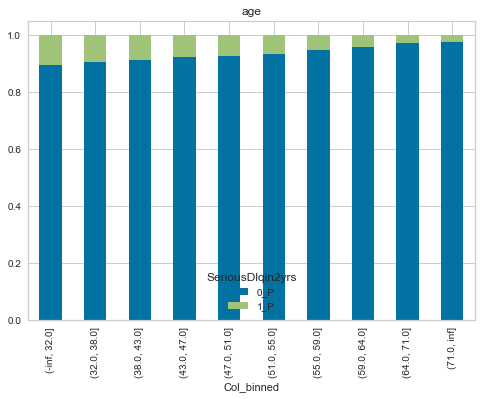

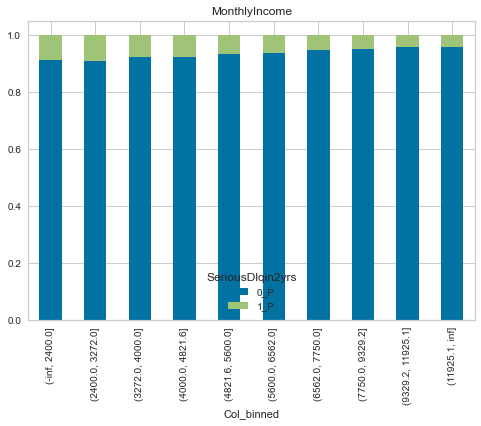

In [66]:
collist=[ 'age', 'MonthlyIncome']
for col in collist:
    df=DecileBadPct(col,cleanedloans)
    ax=df.plot.bar(y=['0_P','1_P'],stacked=True,title=col)
    ax.plot()

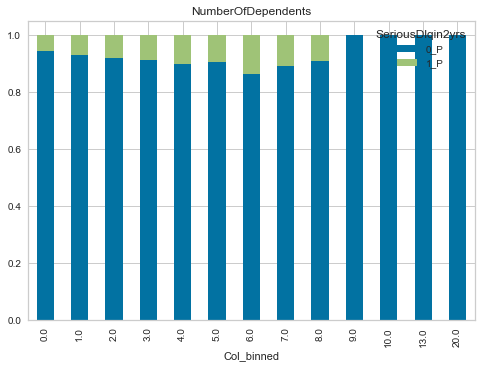

In [67]:
collist=['NumberOfDependents']
for col in collist:
    df=CategoryBadPct(col,cleanedloans)
    ax=df.plot.bar(y=['0_P','1_P'],stacked=True,title=col)
    ax.plot()

From the graphs above we can see that there are some differences in each decile / category of the sociodemographic data, which gives us some clues that the data can be useful as a complement in the analysis but the characteristics by themselves are not as powerful making the risk assessment incomplete if we rely solely on these types of variables.

- *credit behaviour data*

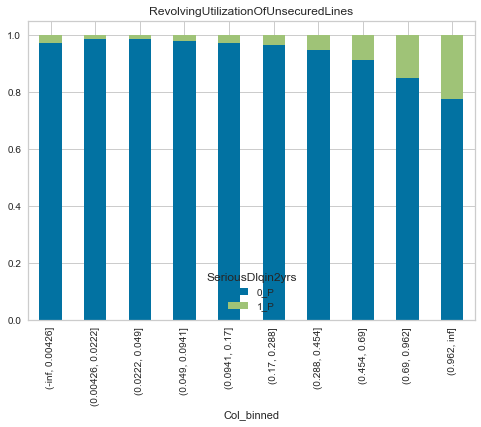

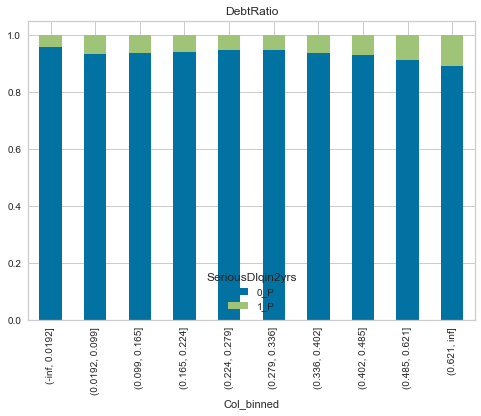

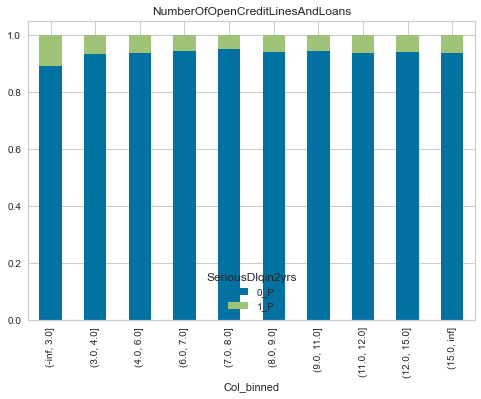

In [68]:
collist=['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans']
for col in collist:
    df=DecileBadPct(col,cleanedloans)
    ax=df.plot.bar(y=['0_P','1_P'],stacked=True,title=col)
    ax.plot()

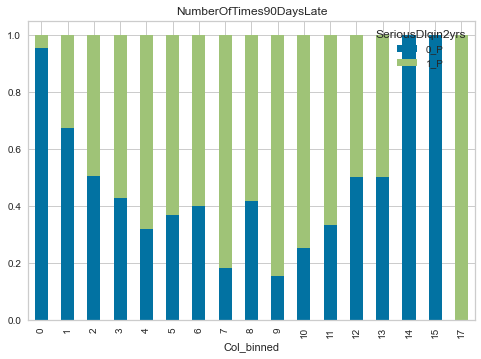

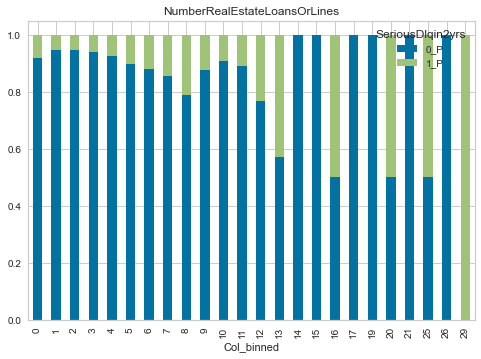

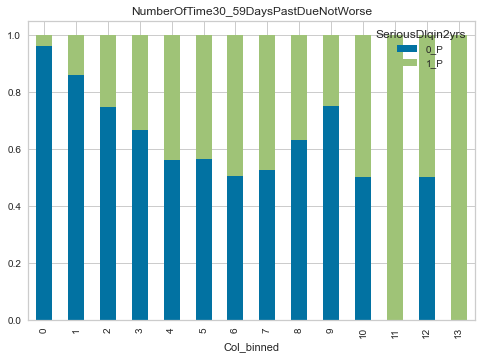

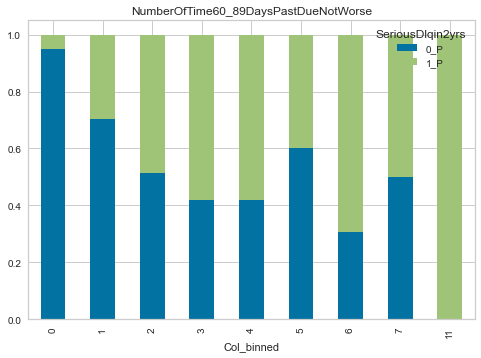

In [69]:
collist=['NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines','NumberOfTime30_59DaysPastDueNotWorse',
         'NumberOfTime60_89DaysPastDueNotWorse']
for col in collist:
    df=CategoryBadPct(col,cleanedloans)
    ax=df.plot.bar(y=['0_P','1_P'],stacked=True,title=col)
    ax.plot()


As we can see, these types of variables give much more information than those of the sociodemographic variables. Note that those are the most relevant variables in any credit studies and give lots of information about your default propensity.

## Model training

- **Define a pipeline**

In [45]:
pipeline = Pipeline(
    [
        ("features", StandardScaler()),
        ("classifier", XGBClassifier()),
    ]
)

- **Data Split**

In [46]:
X = cleanedloans[['RevolvingUtilizationOfUnsecuredLines', 'age','DebtRatio', 'MonthlyIncome','NumberOfOpenCreditLinesAndLoans',
                  'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines','NumberOfDependents',
                  'NumberOfTime30_59DaysPastDueNotWorse', 'NumberOfTime60_89DaysPastDueNotWorse']]
y = cleanedloans['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

- **Training**

In [49]:
names = X.columns

# Cross validation grid definition
hyperparameters = {  "classifier__learning_rate": [0.1, 0.01],
    "classifier__max_depth": [2, 4],
    "classifier__n_estimators": [20, 30, 50],
    "classifier__reg_lambda": [1, 1.5, 2],
    "classifier__gamma": [0, 0.1, 0.3]}
# CV train
Model = GridSearchCV(pipeline, hyperparameters, cv = 10)
 
# Fit and tune model
Model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constrain

# Section 5. Evaluation

- **Metrics**

In [50]:
X_test = pd.DataFrame(X_test, columns=names)
pred_test = Model.predict(X_test)

print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Test Accuraccy:  0.9369064577397911

Confusion Matrix:
[[31253   191]
 [ 1935   317]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     31444
           1       0.62      0.14      0.23      2252

    accuracy                           0.94     33696
   macro avg       0.78      0.57      0.60     33696
weighted avg       0.92      0.94      0.92     33696



From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
could not determine class_counts_ from previously fitted classifier


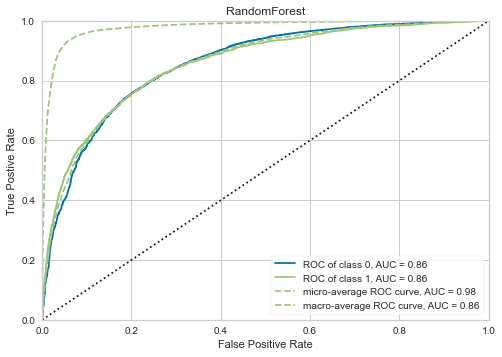

In [51]:
viz =ROCAUC(Model,title="RandomForest")
viz.score(X_test, y_test)
viz.show()

After fitting the model we can observe that we have a pretty good model to accurately asses the credit risk of the customers. To finish the model assessment we are going to see the variable importance to be sure that none of the variables absorbs most of the variability in the data

No handles with labels found to put in legend.


NumberOfTimes90DaysLate                 0.384369
RevolvingUtilizationOfUnsecuredLines    0.253985
NumberOfTime30_59DaysPastDueNotWorse    0.113482
NumberOfTime60_89DaysPastDueNotWorse    0.080396
age                                     0.039836
NumberRealEstateLoansOrLines            0.032930
NumberOfOpenCreditLinesAndLoans         0.030461
DebtRatio                               0.028305
MonthlyIncome                           0.022666
NumberOfDependents                      0.013570
dtype: float32


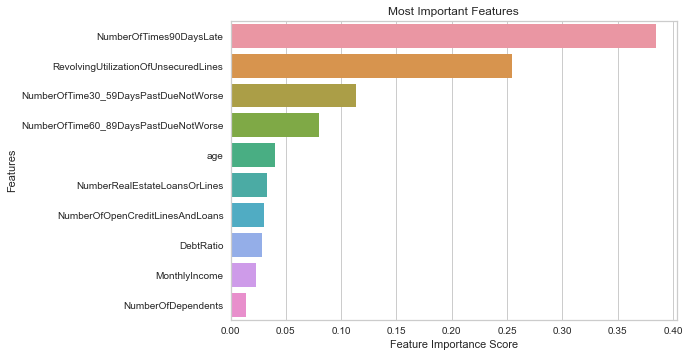

In [52]:
feature_imp = pd.Series(Model.best_estimator_['classifier'].feature_importances_,index=X.columns).sort_values(ascending=False)
print(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Most Important Features")
plt.legend()
plt.show()

From the variable importance we can observe that the model is not rolling solely in one feature concluding that is a very good model.

- **Shap Values** 

Wh

In [53]:
rf_model = Model.best_estimator_['classifier']
new_X_Test = pd.DataFrame(pipeline[:-1].fit_transform(X_test), columns=X.columns)

In [54]:
shap.initjs()
# Create the explainer object
explainer = shap.TreeExplainer(rf_model)
print('Expected Value:', explainer.expected_value)
# get the shap values from the explainer
shap_values = explainer.shap_values(new_X_Test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Expected Value: [-2.76418972]


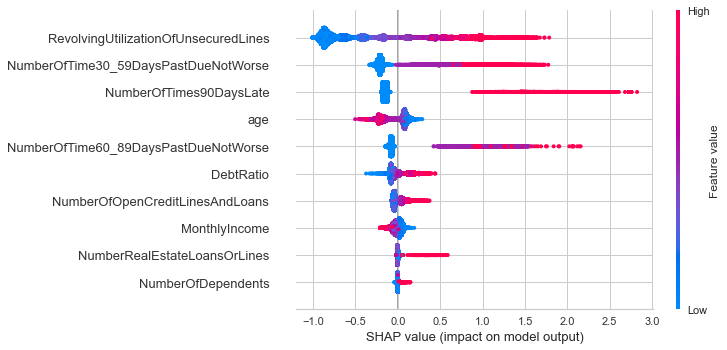

In [61]:
shap.summary_plot(shap_values, new_X_Test,plot_type="dot")

In [62]:
shap.force_plot(explainer.expected_value, shap_values[20,:], new_X_Test.iloc[20,:])

In [63]:
shap.force_plot(explainer.expected_value, shap_values[4,:], new_X_Test.iloc[4,:])